In [1]:
import pandas as pd
import numpy as np
import csv
import math
from sklearn.linear_model import PassiveAggressiveRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime, timedelta
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# import xgboost as xgb

import constants




/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# LOAD DATA

In [2]:
# staticData = load_static_data()
# staticData = transform_to_grid_coordinates(staticData)
# mobileData = load_mobile_sensors()
# mobileData = transform_to_grid_coordinates(mobileData)
# allData = pd.concat([staticData, mobileData], ignore_index=True)
# setIds(staticData)
# setIds(allData)
# allData

with open("all_data_15_min_20_grid.txt", "rb") as fp:   # Unpickling
    all_data = pickle.load(fp)


# Model Functions

In [3]:
#TODO add params for activations, num layers, width of layers, optimizer, loss function, learning rate, batch size
def createStationaryModel():
    online_model = tf.keras.Sequential([
        layers.Dense(8, activation=tf.nn.relu, input_shape=[len(constants.CONTINUOUS_TRAINING_FEATURES)]),
        layers.Dense(8, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    online_optimizer = tf.keras.optimizers.Adam(0.00001)

    online_model.compile(loss='mean_absolute_error',
        optimizer=online_optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error'])
    
#     online_model_w_prev = tf.keras.Sequential([
#         layers.Dense(12, activation=tf.nn.relu, input_shape=[len(constants.CONTINUOUS_TRAINING_FEATURES_W_PREV)]),
#         layers.Dense(16, activation=tf.nn.relu),
# #         layers.Dense(16, activation=tf.nn.relu),
#         layers.Dense(1)
#     ])
#     online_w_prev_optimizer = tf.keras.optimizers.Adam(0.00001)

#     online_model_w_prev.compile(loss='mean_absolute_error',
#         optimizer=online_w_prev_optimizer,
#         metrics=['mean_absolute_error', 'mean_squared_error'])
    
    par = PassiveAggressiveRegressor(C=1, epsilon=0.1, loss='epsilon_insensitive', max_iter=100, random_state=0,tol=1e-3)
    
    return online_model, par


In [4]:
online_model, par_model = createStationaryModel()

Instructions for updating:
Colocations handled automatically by placer.


# Train

In [5]:
def updateModels(data):
    label = data.pop('next_pm_2.5')
    X = data[constants.CONTINUOUS_TRAINING_FEATURES]
    label = np.array(label)
    
    online_model.fit(
        X, label, batch_size=len(data),
        epochs=200, verbose=0)

    par_model.partial_fit(X, label)
                
def trainNNs(train_data):
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
                
    labels = []
    X = pd.DataFrame(columns = constants.CONTINUOUS_TRAINING_FEATURES)
    
    start = int(train_data['timestepContinuous'].min())
    end = int(train_data['timestepContinuous'].max())
    for i in range(start, end):
        cur_data = train_data[train_data['timestepContinuous'] == i]
        #Get list of all coords
        lat_coords = np.array(cur_data['lat_grid'])
        long_coords = np.array(cur_data['long_grid'])
                
        for x, y in zip(lat_coords, long_coords):
            x = int(x)
            y = int(y)
            
            #Check which coords have data next step
            if(grid_labels[i + 1][x][y] != None):
                #Append curData for coords that do have data next step
                new_input = cur_data[(cur_data['lat_grid'] == x) & (cur_data['long_grid'] == y)][constants.CONTINUOUS_TRAINING_FEATURES]
                X = pd.concat([X, new_input])
                #Append grid data to labels
                labels.append(grid_labels[i + 1][x][y])
        
    early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=50)

    par_model.fit(X, labels)

    history = online_model.fit(
        X, labels, batch_size=16,
        epochs=1000, verbose=0, validation_split = .2, callbacks=[ early_stop, PrintDot()])

    plot_history(history)
    hist = pd.DataFrame(history.history)
    display(hist)
    
def trainNNnn(trainData):
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
                
    
        
    X = trainData[constants.CONTINUOUS_TRAINING_FEATURES]
    labels = trainData.pop('next_pm_2.5')
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

    par_model.fit(X, labels)

    history = online_model.fit(
        X, labels, batch_size=8,
        epochs=1000, verbose=0, validation_split = .2, callbacks=[ early_stop, PrintDot()])

    plot_history(history)
    hist = pd.DataFrame(history.history)
    display(hist)
    
        
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()

In [6]:
train = all_data[all_data['timestepContinuous'] <= 1450]
valid = all_data[(all_data['timestepContinuous'] > 1450)]
# train = all_data[(all_data['timestepContinuous'] < 869) | (all_data['timestepContinuous'] > 1119)]
# valid = all_data[(all_data['timestepContinuous'] >= 869) & (all_data['timestepContinuous'] <= 1119)]
# train = all_data[(all_data['timestepContinuous'] < 97) | (all_data['timestepContinuous'] > 447)]
# valid = all_data[(all_data['timestepContinuous'] >= 97) & (all_data['timestepContinuous'] <= 447)]

# Train Functions

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................................................

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,2.151024,2.151024,7.107993,2.330511,2.330511,10.567316
1,1.959612,1.959612,6.294244,2.136491,2.136491,9.704839
2,1.745403,1.745404,5.489979,1.885159,1.885158,8.732369
3,1.468371,1.468370,4.586205,1.604736,1.604736,7.770603
4,1.175929,1.175930,3.790845,1.314886,1.314885,6.911953
...,...,...,...,...,...,...
490,0.396817,0.396817,1.644406,0.563048,0.563048,2.863969
491,0.396795,0.396795,1.644409,0.562958,0.562958,2.865225
492,0.396752,0.396752,1.644737,0.563115,0.563114,2.865413
493,0.396754,0.396754,1.644884,0.563169,0.563169,2.864475


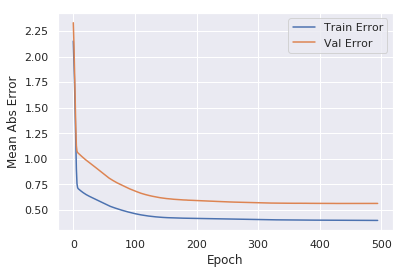

In [7]:
# trainNNs(train)
trainNNnn(train)

In [8]:
with open("grid_labels_20.txt", "rb") as fp:   # Unpickling
    grid_labels = pickle.load(fp)

# Test Time Functions

In [19]:
def copy_model(model):
    batch_model = keras.models.clone_model(model)
    batch_model.build((None, len(constants.CONTINUOUS_TRAINING_FEATURES)))
    batch_model.compile(optimizer='adam', loss='mean_absolute_error')
    batch_model.set_weights(model.get_weights())
    
    return batch_model

def predictOneTimestep(data):
    online_pred_matrix = [[None for x in range(constants.GRID_SIZE)] for y in range(constants.GRID_SIZE)]
    batch_pred_matrix = [[None for x in range(constants.GRID_SIZE)] for y in range(constants.GRID_SIZE)]
    par_pred_matrix = [[None for x in range(constants.GRID_SIZE)] for y in range(constants.GRID_SIZE)]
    
    #get each datapoint in df and check coords and place in grid
    if (len(data) > 0):
        for index, row in data.iterrows():
            x = int(row['lat_grid'])
            y = int(row['long_grid'])
            columns = list(row.index)
            
            if([x,y] in constants.STATIC_COORDS_GRID.values()):
                online_pred, batch_pred, par_pred = predictOneDataPoint(pd.DataFrame(row).transpose())
                online_pred_matrix[x][y] = online_pred
                batch_pred_matrix[x][y] = batch_pred
                par_pred_matrix[x][y] = par_pred

    return online_pred_matrix, batch_pred_matrix, par_pred_matrix

def predictOneDataPoint(X):
    X = np.array(X[constants.CONTINUOUS_TRAINING_FEATURES])
    online_pred = online_model.predict(X)
    batch_pred = batch_model.predict(X)
    par_pred = par_model.predict(X)
    
    return (online_pred[0][0], batch_pred[0][0], par_pred[0])

def interpolate(pred_matrix):

    data = np.array([[x, y, pred_matrix[x][y]] for x in range(constants.GRID_SIZE) for y in range(constants.GRID_SIZE) if pred_matrix[x][y] != None])
    if(len(data) > 0):
        ok = OrdinaryKriging(data[:,0], data[:,1], data[:,2], variogram_model='gaussian', verbose=False, enable_plotting=False)
        gridx = np.arange(0.0, constants.GRID_SIZE, 1)
        gridy = np.arange(0.0, constants.GRID_SIZE, 1)
        z, ss = ok.execute('grid', gridx, gridy)
        return z
    else:
        return pred_matrix
    
def get_valid_preds(timestep, online_pred_matrix, batch_pred_matrix, par_pred_matrix):
    labels = []
    online_preds = []
    batch_preds = []
    par_preds = []
    
    for x in range(constants.GRID_SIZE):
        for y in range(constants.GRID_SIZE):
#             if(grid_labels[timestep + 1][x][y] != None and [x,y] not in constants.STATIC_COORDS_GRID.values()):
            if(grid_labels[timestep + 1][x][y] != None):
                online_preds.append(online_pred_matrix[x][y])
                batch_preds.append(batch_pred_matrix[x][y])
                par_preds.append(par_pred_matrix[x][y])
                labels.append(grid_labels[timestep + 1][x][y])
    
    return (np.array(online_preds), np.array(batch_preds), par_preds, labels)
    

def getFullPredictions(data):
    online_predictions = []
    batch_predictions = []
    ensemble = []
    par_predictions = []
    all_labels = []
    
    flat_online_preds = []
    flat_batch_preds = []
    flat_par_preds = []
    flat_ensemble_preds = []
    raw_online_preds = []
    raw_batch_preds = []
    online_errors = []
    batch_errors = []
    online_avg_error = 0
    batch_avg_error = 0
    
    for i in range(int(data['timestepContinuous'].min()), int(data['timestepContinuous'].max() - 1)):
#     for i in range(1522, 1550):
        newData = data[data['timestepContinuous'] == i]
        
        if(len(newData) > 1):
            online_pred_matrix, batch_pred_matrix, par_pred_matrix = predictOneTimestep(newData)

            int_online_pred_matrix = interpolate(online_pred_matrix)
            int_batch_pred_matrix = interpolate(batch_pred_matrix)
            int_par_pred_matrix = interpolate(par_pred_matrix)
            
            raw_online_pred, raw_batch_pred, par_pred, labels = get_valid_preds(i, int_online_pred_matrix, int_batch_pred_matrix, int_par_pred_matrix)
            
            if(math.isnan(online_avg_error) != True):
                online_pred = raw_online_pred + online_avg_error
                batch_pred = raw_batch_pred + batch_avg_error
            else:
                online_pred = raw_online_pred
                batch_pred = raw_batch_pred
                
#             flat_online_preds.extend(online_pred)
#             flat_batch_preds.extend(batch_pred)
#             flat_par_preds.extend(par_pred)
            flat_online_preds.extend(raw_online_pred)
            flat_batch_preds.extend(raw_batch_pred)
            flat_par_preds.extend(par_pred)
            all_labels.extend(labels)
            
            online_error = labels - raw_online_pred
            online_errors.extend(online_error)
            
            batch_error = labels - raw_batch_pred
            batch_errors.extend(batch_error)
            
           
            online_avg_error = np.mean(online_errors)
            batch_avg_error = np.mean(batch_errors)

            
#             online_predictions.append(int_online_pred_matrix)
#             par_predictions.append(int_par_pred_matrix)
#             batch_predictions.append(int_batch_pred_matrix)

            
#             ensemble_pred_matrix = np.add((.5 * int_online_pred_matrix) + (.5 * int_batch_pred_matrix))
           
            ensemble_pred = np.add((.5 * raw_online_pred), (.5 * raw_batch_pred))
#             ensemble_pred = np.add((.5 * online_pred), (.5 * batch_pred))
            

            flat_ensemble_preds.extend(ensemble_pred)
            
            updateModels(newData)
    return (flat_online_preds, flat_batch_preds, flat_par_preds, flat_ensemble_preds, all_labels)


In [20]:
batch_model = copy_model(online_model)
online_preds, batch_predictions, par_preds,ensemble_preds, labels = getFullPredictions(valid)
print('online with bias correction error: {}'.format(mean_absolute_error(np.array(online_preds), np.array(labels))))
print('batch with bias correction error: {}'.format(mean_absolute_error(batch_predictions, labels)))
print('ensemble with bias correction error: {}'.format(mean_absolute_error(ensemble_preds, labels)))
print('par error: {}'.format(mean_absolute_error(par_preds, labels)))

online with bias correction error: 0.32881760247544106
batch with bias correction error: 0.3581081236817382
ensemble with bias correction error: 0.33569600381170506
par error: 0.38693373680360216


In [12]:
osm_dir = "/Users/ryanegan/Documents/diss/"
filename = osm_dir + "prediction_sample_grid_" + str(constants.GRID_SIZE) + ".csv"
with open(filename, 'w') as csvfile:
    writer = csv.writer(csvfile, lineterminator='\n')
    writer.writerows(online_preds[300])

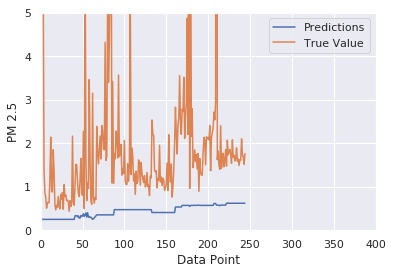

In [14]:
def plot_preds(preds, labels):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

    x = range(len(preds))
    plt.figure()
    plt.xlabel('Data Point')
    plt.ylabel('PM 2.5')
    plt.plot(x, preds,
           label='Predictions')
    plt.plot(x, labels,
           label = 'True Value')
    plt.ylim([0,5])
    plt.xlim([0, 400])
    plt.legend()

    plt.show()

plot_preds(ensemble_preds, labels)


In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
print(mean_absolute_percentage_error(np.array(online_preds), np.array(labels)))
print(mean_absolute_percentage_error(batch_predictions, labels))
print(mean_absolute_percentage_error(ensemble_preds, labels))
print(mean_absolute_percentage_error(par_preds, labels))

411.34706523462523
386.56536318874885
397.9470440936944
436.506992207763
